In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly, json
import plotly.express as px
from urllib.request import urlopen

sns.set_style("whitegrid")

In [8]:
pip install -U kaleido

In [11]:
conda update -n base -c defaults conda

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - conda


The following packages will be REMOVED:

  python_abi-3.8-2_cp38

The following packages will be UPDATED:

  ca-certificates    conda-forge::ca-certificates-2022.9.2~ --> pkgs/main::ca-certificates-2022.10.11-haa95532_0 None

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2022.9.24~ --> pkgs/main/win-64::certifi-2022.9.24-py38haa95532_0 None
  conda              conda-forge::conda-22.9.0-py38haa244f~ --> pkgs/main::conda-22.9.0-py38haa95532_0 None


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly==5.11.0

Note: you may need to restart the kernel to use updated packages.


In [111]:
# Get data for specific groups of people (you only want one data point per county when you plot)
import numpy as np
import pandas as pd
import plotly, json
import plotly.express as px
from urllib.request import urlopen

# Get county/mort stuff
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response: counties = json.load(response)
mort = pd.read_csv('C:/Users/Ethel/Capstone/Capstone-/data/mort_with_15yrpoverty.csv',dtype={"FIPS": str})

# The function
def flatten_df(df, filter_by = {}, save_fn = None): 
    
    sort_by = {'Gender Code' : None,
               'Race' : None,
               'Hispanic Origin' : None,
               'Interval' : None,
               'Age Group Code': None,
               'State' : None}
    county_level_cols = ['County','5_Year_Avg_Poverty_Estimate','Total 5yrAvg County Population',
                         'Total 5yrAvg County Population','Total 5yrAvg County Deaths',
                         'Total 5yrAvg State Population','Total 5yrAvg State Deaths',
                         'Total 15yrAvg County Population','Total 15yrAvg County Deaths',
                         'Total 15yrAvg State Population','Total 15yrAvg State Deaths']
    '''
    ,'CO 2nd Max 1-hr', 'CO 2nd Max 8-hr','NO2 98th Percentile 1-hr', 
    'NO2 Mean 1-hr', 'Ozone 2nd Max 1-hr', 'Ozone 4th Max 8-hr', 
    'SO2 99th Percentile 1-hr', 'SO2 2nd Max 24-hr','SO2 Mean 1-hr', 
    'PM2.5 98th Percentile 24-hr', 'PM2.5 Weighted Mean 24-hr', 
    'PM10 2nd Max 24-hr', 'Lead Max 3-Mo Avg',
    '''
    
    # Check for bad input
    for key in filter_by.keys(): 
        if key not in sort_by: 
            print('Unrecognized key in filter_by dict.')
            return
    
    for key in filter_by:
        if filter_by[key] != None: sort_by[key] = filter_by[key]
    
    # Remove all unnecesary data from the df
    temp_df = df.copy(deep=True)

    for key,val in sort_by.items():
        if val == None: 
            temp_df = temp_df.drop(columns=key)
        else:    
            temp_df = temp_df.loc[np.asarray(temp_df[key]==val)]
            
    # Flatten remaining data points so that there are no repeated counties/FIPS
    fips,ind = np.unique(temp_df['FIPS'],return_index=True)
    
    ### Get values that are constant for different groups in the same county
    county_levels = {}
    for col in county_level_cols:
        county_levels[col] = np.asarray(temp_df[col])[ind]
        
    ### Calculate the values that change with different groups in the same county
    deaths = []
    population = []
    for fip in fips:
        mask = np.asarray(temp_df['FIPS']==fip)
        single_county_df = temp_df.loc[mask]
        deaths.append(np.sum(single_county_df['Deaths']))
        population.append(np.sum(single_county_df['Population']))
    
    ### Calculate deaths and population per year
    if sort_by['Interval'] != None: num_years = 5
    else: num_years = 15
    deaths = np.asarray(deaths)/num_years
    population = np.asarray(population)/num_years
        
    flattened_df = pd.DataFrame(data={'FIPS': fips, 'Deaths': deaths, 'Population': population})
    for col in county_level_cols:
        flattened_df[col] = county_levels[col]
    
    # Save to CSV if necessary
    if save_fn != None:
        flattened_df.to_csv(save_fn)
    
    return flattened_df # dataframe with single row for each county containing deaths, population, poverty, and polution

In [470]:
# Example of use:
mort_flattened = flatten_df(mort,{'Race':'White','Interval':'2002-2006'})
mort_flattened

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths
0,01001,313.2,25103.6,"Autauga County, AL",5090.6,29910.0,396.4,3267387.0,45393.2,32042.933333,436.133333,3.353935e+06,47131.000000
1,01003,1393.2,112180.6,"Baldwin County, AL",16183.6,120371.0,1524.6,3267387.0,45393.2,133171.666667,1722.066667,3.353935e+06,47131.000000
2,01005,168.8,7648.4,"Barbour County, AL",5906.8,14970.8,282.8,3267387.0,45393.2,13907.333333,267.600000,3.353935e+06,47131.000000
3,01007,180.6,10160.2,"Bibb County, AL",3352.6,11280.0,206.2,3267387.0,45393.2,12391.600000,215.466667,3.353935e+06,47131.000000
4,01009,517.8,37027.8,"Blount County, AL",6396.2,37027.8,517.8,3267387.0,45393.2,37446.000000,550.333333,3.353935e+06,47131.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,56037,239.0,20823.0,"Sweetwater County, WY",2832.8,20823.0,239.0,280776.0,3845.2,23872.066667,243.133333,3.062673e+05,4045.533333
3143,56039,67.0,8138.2,"Teton County, WY",975.0,8138.2,67.0,280776.0,3845.2,8629.533333,71.000000,3.062673e+05,4045.533333
3144,56041,105.8,7574.8,"Uinta County, WY",1897.8,7574.8,105.8,280776.0,3845.2,10038.333333,117.866667,3.062673e+05,4045.533333
3145,56043,76.6,2813.8,"Washakie County, WY",841.0,2813.8,76.6,280776.0,3845.2,3246.066667,75.933333,3.062673e+05,4045.533333


In [6]:
#This gives all the options for the different columns  
print(np.unique(np.asarray(mort['Race'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Age Group Code'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Hispanic Origin'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Gender Code'],dtype=str)),'\n')
print(np.unique(np.asarray(mort['Interval'],dtype=str)))


['American Indian or Alaska Native' 'Asian or Pacific Islander'
 'Black or African American' 'White' 'nan'] 

['1' '1-4' '10-14' '15-19' '20-24' '25-34' '35-44' '45-54' '5-9' '55-64'
 '65-74' '75-84' '85+' 'NS' 'nan'] 

['Hispanic or Latino' 'Not Hispanic or Latino' 'Not Stated' 'nan'] 

['F' 'M' 'nan'] 

['2002-2006' '2007-2011' '2012-2016']


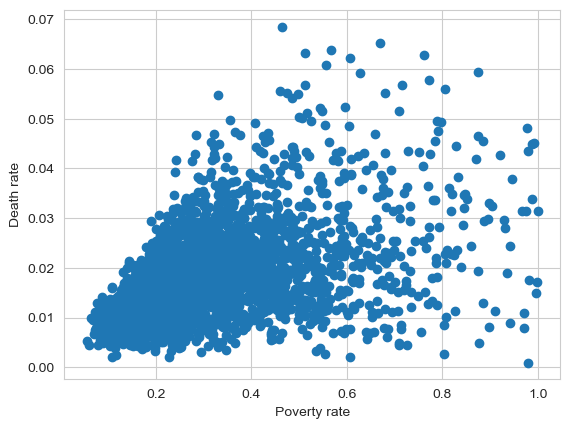

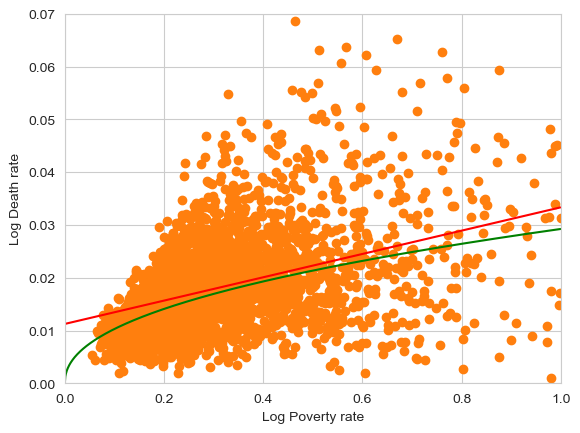

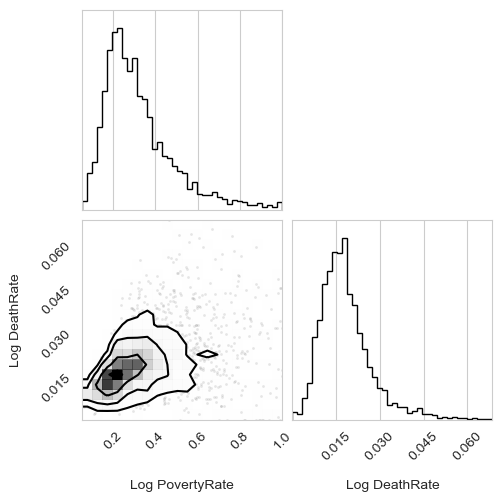

In [465]:
# Plotting 4 graphs from the previous dataframe 
mort_flattened.loc[:,'PovertyRate'] = mort_flattened.loc[:,'5_Year_Avg_Poverty_Estimate']/mort_flattened.loc[:,'Total 5yrAvg County Population']
mort_flattened.loc[:,'DeathRate'] = (mort_flattened.loc[:,'Deaths']/mort_flattened.loc[:,'Total 5yrAvg County Population'])
mort_flattened2 = mort_flattened[mort_flattened.PovertyRate<=1].reset_index(drop=True)
mort_flattened_log = mort_flattened2[~((mort_flattened2.DeathRate==0) | (mort_flattened2.PovertyRate==0))]

# Plots the first linear graph
plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
plt.xlabel("Poverty rate")
plt.ylabel("Death rate")
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2012-2016PovertyvsDeathrates.png')
plt.show()

# log plots
# defining the x and y values 
y = np.log10(mort_flattened_log.DeathRate)
x = np.log10(mort_flattened_log.PovertyRate)
y2 = mort_flattened2.DeathRate
x2 = mort_flattened2.PovertyRate
# linear coefficients for the polyfit 
poly_coeef = np.polyfit(x,y,1)
poly_coef_linear = np.polyfit(x2,y2,1)

# Making a line for the polyfit
xfit = np.arange(-10,2,0.1)
yfit = np.polyval(poly_coeef,xfit)

# make second plot (log-log)
plt.scatter(x,y)
plt.plot(xfit,yfit, color='red')
plt.xlabel("Log Poverty rate")
plt.ylabel("Log Death rate")
plt.xlim(-1.5,0.5)
plt.ylim(-4,-1)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2012-2016loglog_DeathvsPoverty_linfit.png')

# make third plot ( linear + log fit) 
xfit2 = np.arange(0,1,0.001)
yfit2 = np.polyval(poly_coef_linear,xfit2)
yfit3 = 10**(poly_coeef[1]) * xfit2**(poly_coeef[0])

plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
plt.plot(xfit2,yfit2, color='red')
plt.plot(xfit2,yfit3, color='green')
plt.xlim(0,1)
plt.ylim(0,0.07)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2012-2016DeathvsPoverty_linfit_logfit.png')

# make fourth plot (corner)
matlog1 = np.array(mort_flattened2.dropna()[['PovertyRate', 'DeathRate']])
figure = corner.corner(matlog1, labels=['Log PovertyRate', 'Log DeathRate'], hist_bin_factor=[2,2])
figure.savefig("C:/Users/Ethel/Capstone/Capstone-/2012-2016corner.png")

In [460]:
mort_flattened_log.sample(10)

,FIPS,Deaths,Population,County,5_Year_Avg_Poverty_Estimate,Total 5yrAvg County Population,Total 5yrAvg County Deaths,Total 5yrAvg State Population,Total 5yrAvg State Deaths,Total 15yrAvg County Population,Total 15yrAvg County Deaths,Total 15yrAvg State Population,Total 15yrAvg State Deaths,PovertyRate,DeathRate
1728,34035,119.4,14317.6,"Somerset County, NJ",12951.8,207214.8,2026.4,6523676.4,71403.0,2.132248e+05,2130.000000,6.563251e+06,70445.933333,0.062504,0.000576
505,13299,92.6,4574.6,"Ware County, GA",6470.6,20742.6,424.6,5843668.8,63580.4,1.990480e+04,426.733333,6.291555e+06,68393.533333,0.311947,0.004464
2714,51041,226.8,34946.8,"Chesterfield County, VA",16808.8,208383.0,1619.4,4841318.6,55008.2,2.190804e+05,1881.200000,5.072606e+06,57603.000000,0.080663,0.001088
1628,31055,422.0,39701.8,"Douglas County, NE",51561.6,360204.6,3543.4,1006890.4,14264.4,3.940269e+05,3687.266667,1.061738e+06,14640.200000,0.143145,0.001172
2210,42081,19.6,1312.2,"Lycoming County, PA",13211.6,90343.2,1224.8,10206799.2,127252.0,8.631987e+04,1230.600000,1.009814e+07,126686.933333,0.146238,0.000217
2451,48029,827.8,82082.4,"Bexar County, TX",241558.2,1418278.4,10431.2,17767332.2,150138.2,1.558672e+06,11305.266667,1.954813e+07,162796.333333,0.170318,0.000584
2748,51111,44.8,1760.0,"Lunenburg County, VA",2169.0,4892.0,134.6,4841318.6,55008.2,5.186200e+03,132.600000,5.072606e+06,57603.000000,0.443377,0.009158
192,06039,29.4,1417.4,"Madera County, CA",24441.0,81364.8,889.6,31648093.2,233999.0,8.937560e+04,942.266667,3.245140e+07,238767.133333,0.300388,0.000361
353,12111,285.0,25091.0,"St. Lucie County, FL",27582.4,173847.6,2386.2,14837177.2,167281.6,1.985451e+05,2662.733333,1.560747e+07,173664.533333,0.158659,0.001639
497,13283,9.8,181.8,"Treutlen County, GA",1548.0,1732.2,59.8,5843668.8,63580.4,1.813800e+03,60.133333,6.291555e+06,68393.533333,0.893661,0.005658


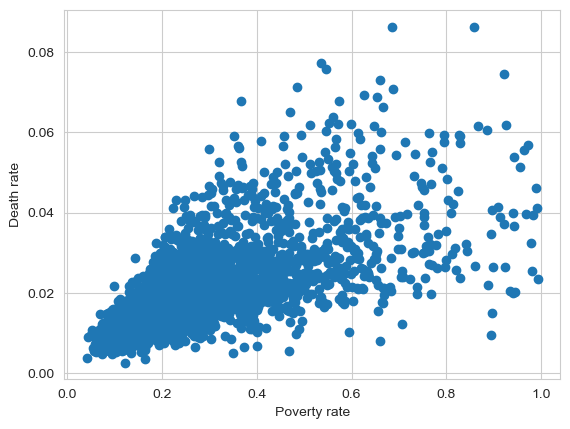

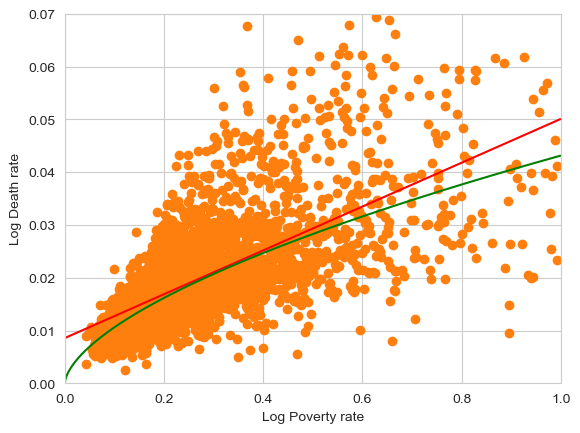

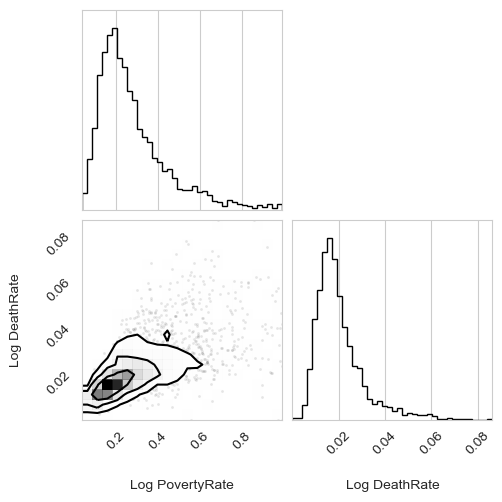

In [471]:
# All deaths independent of race
# Plotting 4 graphs from the previous dataframe 
mort_flattened.loc[:,'PovertyRate'] = mort_flattened.loc[:,'5_Year_Avg_Poverty_Estimate']/mort_flattened.loc[:,'Total 5yrAvg County Population']
mort_flattened.loc[:,'DeathRate'] = (mort_flattened.loc[:,'Total 5yrAvg County Deaths']/mort_flattened.loc[:,'Total 5yrAvg County Population'])
mort_flattened2 = mort_flattened[mort_flattened.PovertyRate<=1].reset_index(drop=True)
mort_flattened_log = mort_flattened2[~((mort_flattened2.DeathRate==0) | (mort_flattened2.PovertyRate==0))]

# Plots the first linear graph
plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
plt.xlabel("Poverty rate")
plt.ylabel("Death rate")
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2002-2006PovertyvsDeathrates_allraces.png')
plt.show()

# log plots
# defining the x and y values 
y = np.log10(mort_flattened_log.DeathRate)
x = np.log10(mort_flattened_log.PovertyRate)
y2 = mort_flattened2.DeathRate
x2 = mort_flattened2.PovertyRate
# linear coefficients for the polyfit 
poly_coeef = np.polyfit(x,y,1)
poly_coef_linear = np.polyfit(x2,y2,1)

# Making a line for the polyfit
xfit = np.arange(-10,2,0.1)
yfit = np.polyval(poly_coeef,xfit)

# make second plot (log-log)
plt.scatter(x,y)
plt.plot(xfit,yfit, color='red')
plt.xlabel("Log Poverty rate")
plt.ylabel("Log Death rate")
plt.xlim(-1.5,0.5)
plt.ylim(-3,-1)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2002-2006loglog_DeathvsPoverty_linfit_allraces.png')

# make third plot ( linear + log fit) 
xfit2 = np.arange(0,1,0.001)
yfit2 = np.polyval(poly_coef_linear,xfit2)
yfit3 = 10**(poly_coeef[1]) * xfit2**(poly_coeef[0])

plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
plt.plot(xfit2,yfit2, color='red')
plt.plot(xfit2,yfit3, color='green')
plt.xlim(0,1)
plt.ylim(0,0.07)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2002-2006DeathvsPoverty_linfit_logfit_allraces.png')

# make fourth plot (corner)
matlog1 = np.array(mort_flattened2.dropna()[['PovertyRate', 'DeathRate']])
figure = corner.corner(matlog1, labels=['Log PovertyRate', 'Log DeathRate'], hist_bin_factor=[2,2])
figure.savefig("C:/Users/Ethel/Capstone/Capstone-/2002-2006corner_allraces.png")

In [441]:
poly_coeef

array([ 0.49884019, -1.51843963])

 $\log(PovertyRate) = 0.98 + 0.58\log(DeathRate)$\
 $PovertyRate = 10^{0.98}10^{0.58\log(DeathRate)}$\
 $PovertyRate = 10^{0.98}10^{\log(DeathRate^{0.58})}$\
 $PovertyRate = 10^{0.98}  DeathRate^{0.58}$
 
 
 

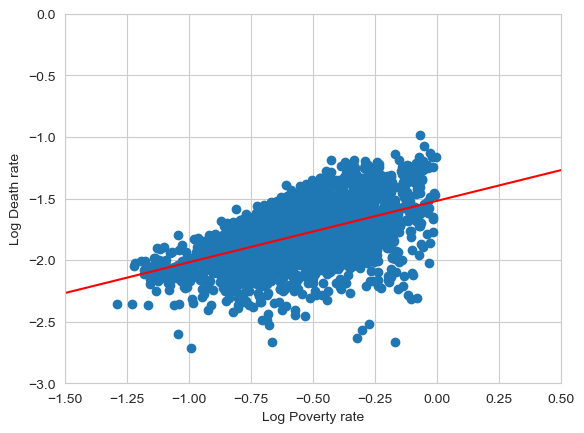

In [443]:
plt.scatter(x,y)
plt.plot(xfit,yfit, color='red')
plt.xlabel("Log Poverty rate")
plt.ylabel("Log Death rate")
plt.xlim(-1.5,0.5)
plt.ylim(-3,0)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2007-2011loglog_DeathvsPoverty_linfit.png')

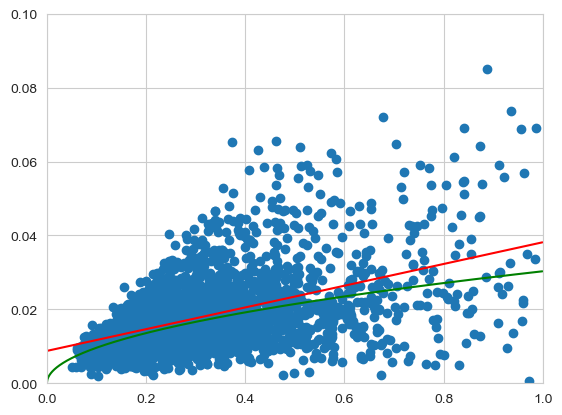

In [444]:
# This calculates deaths vs poverty  
xfit2 = np.arange(0,1,0.001)
yfit2 = np.polyval(poly_coef_linear,xfit2)
yfit3 = 10**(poly_coeef[1]) * xfit2**(poly_coeef[0])

plt.scatter(mort_flattened_log.PovertyRate, mort_flattened_log.DeathRate)
plt.plot(xfit2,yfit2, color='red')
plt.plot(xfit2,yfit3, color='green')
plt.xlim(0,1)
plt.ylim(0,0.1)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2007-2011DeathvsPoverty_linfit_logfit.png')

This is the linear fit to linear data

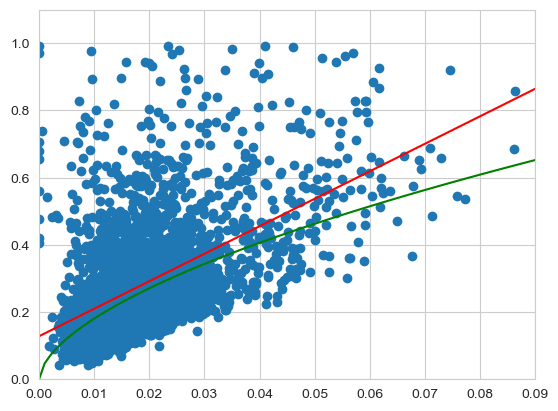

In [396]:
# This plots poverty vs death 
xfit2 = np.arange(0,0.1,0.001)
yfit2 = np.polyval(poly_coef_linear,xfit2)
yfit3 = 10**(poly_coeef[1]) * xfit2**(poly_coeef[0])

plt.scatter(x2,y2)
plt.plot(xfit2,yfit2, color='red')
plt.plot(xfit2,yfit3, color='green')
plt.xlim(0,0.09)
plt.ylim(0,1.1)
plt.savefig('C:/Users/Ethel/Capstone/Capstone-/2002-2006PovertyvsDeath_linfit_logfit.png')

In [364]:
import scipy

In [365]:
linregres = scipy.stats.linregress(x2,y2)

In [371]:
poly_coef_linear

array([8.18003242, 0.12821684])

In [367]:
linregres

LinregressResult(slope=8.180032421873024, intercept=0.12821683869415262, rvalue=0.5335659236558381, pvalue=1.4299270445151733e-221, stderr=0.23617921571359163)

In [ ]:
scipy.stats.linregress(x, y=None, alternative='two-sided')

In [372]:
from sklearn.metrics import r2_score

In [380]:
np.sqrt(r2_score(y2,10**(poly_coeef[1]) * x2**(poly_coeef[0])))

0.47872172913880534

In [379]:
np.sqrt(r2_score(y2,np.polyval(poly_coef_linear,x2)))

0.5335659236558379

In [458]:
matlog1 = np.array(mort_flattened2.dropna()[['PovertyRate', 'DeathRate']])

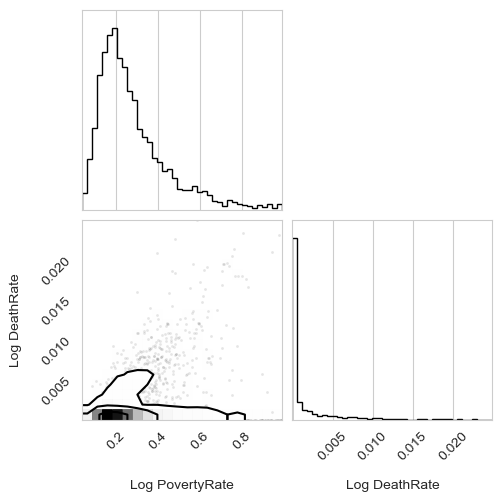

In [459]:
figure = corner.corner(matlog1, labels=['Log PovertyRate', 'Log DeathRate'], hist_bin_factor=[2,2])
figure.savefig("corner.png")

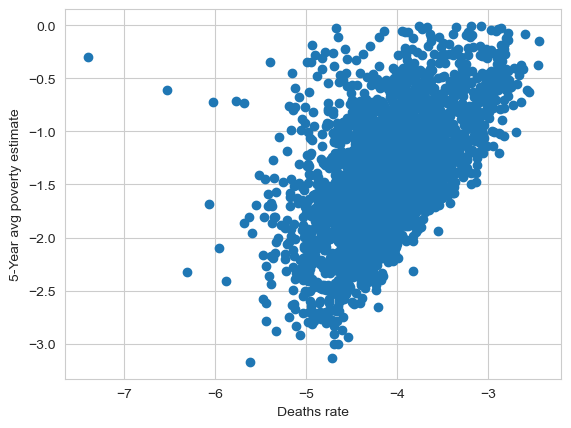

In [277]:
plt.scatter(np.log(mort_flattened2.DeathRate), np.log(mort_flattened2.PovertyRate))
plt.xlabel("Deaths rate")
plt.ylabel("5-Year avg poverty estimate")
plt.show()

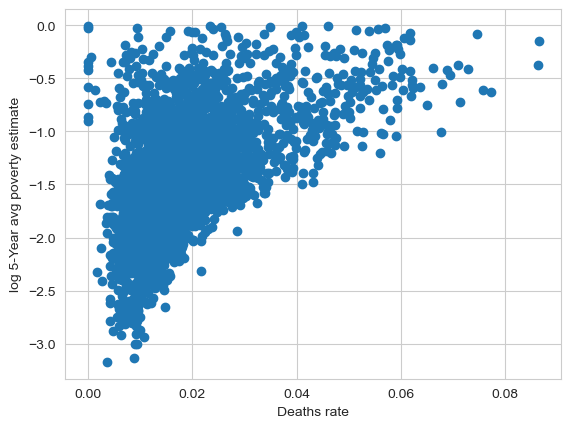

In [279]:
plt.scatter(mort_flattened2.DeathRate, np.log(mort_flattened2.PovertyRate))
plt.xlabel("Deaths rate")
plt.ylabel("log 5-Year avg poverty estimate")
# np.polyfit(np.log(mort_flattened2.DeathRate),np.log(mort_flattened2.PovertyRate),1)
plt.show()

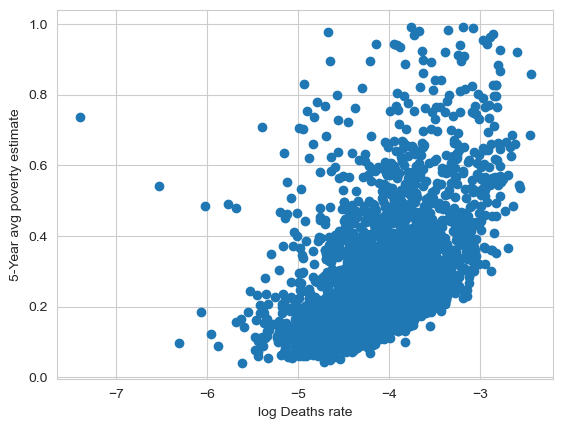

In [281]:
plt.scatter(np.log(mort_flattened2.DeathRate), mort_flattened2.PovertyRate)
plt.xlabel("log Deaths rate")
plt.ylabel("5-Year avg poverty estimate")
# np.polyfit(np.log(mort_flattened2.DeathRate),np.log(mort_flattened2.PovertyRate),1)
plt.show()

In [109]:
mort_flattened.max()

FIPS                                         55133
Deaths                                     3349.27
Population                                  664078
County                             Yuba County, CA
5_Year_Avg_Poverty_Estimate            1.78295e+06
Total 5yrAvg County Population         9.79231e+06
Total 5yrAvg County Deaths                   60541
Total 5yrAvg State Population          3.34727e+07
Total 5yrAvg State Deaths                   249393
Total 15yrAvg County Population        9.61774e+06
Total 15yrAvg County Deaths                59467.9
Total 15yrAvg State Population         3.24514e+07
Total 15yrAvg State Deaths                  238767
dtype: object

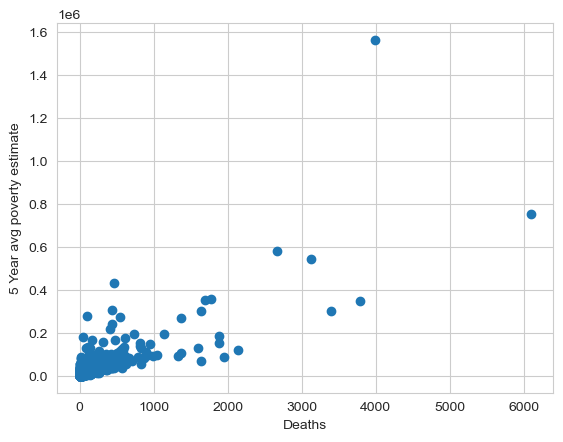

In [104]:
plt.scatter(mort_flattened.Deaths, mort_flattened['5_Year_Avg_Poverty_Estimate'],)
plt.xlabel("Deaths")
plt.ylabel("5 Year avg poverty estimate")
plt.show()

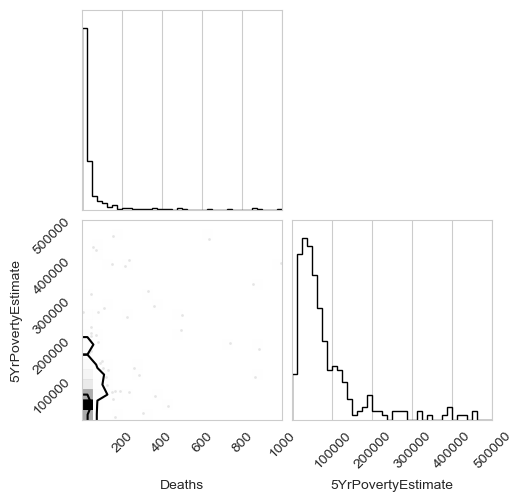

In [110]:
import numpy as np
import corner

figure = corner.corner(mat1, range=[(0,1000), (0,0.5e6)], labels=['Deaths', '5YrPovertyEstimate'], hist_bin_factor=[2,2])
figure.savefig("corner.png")

In [50]:
mort_flattened['5_Year_Avg_Poverty_Estimate'].describe()

count    3.460000e+02
mean     7.788171e+04
std      1.256663e+05
min      1.470000e+03
25%      2.355550e+04
50%      4.529400e+04
75%      8.061985e+04
max      1.589087e+06
Name: 5_Year_Avg_Poverty_Estimate, dtype: float64